In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocessing
from sklearn.cluster import DBSCAN
from sklearn import linear_model
import scipy.interpolate as ip
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import scipy as sp
from sklearn.metrics import silhouette_score, silhouette_samples
from itertools import combinations

In [2]:
data = pd.read_csv('Indicators.csv')
data.shape

(5656458, 6)

In [3]:
data.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,1.335609e+02
1,Arab World,ARB,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,8.779760e+01
2,Arab World,ARB,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,6.634579e+00
3,Arab World,ARB,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,8.102333e+01
4,Arab World,ARB,Arms exports (SIPRI trend indicator values),MS.MIL.XPRT.KD,1960,3.000000e+06


In [4]:
def corr(data, column):
    data=data[(data['Year'] >= 2000) & (data['Year'] < 2014) ]
    for i in data.columns:
        if data.isna().sum()[i]/len(data) >=0.8:
            data=data.drop(columns=[i])

    rel_columns= []
    rel_columns_7=[]
    unique_name = data['IndicatorName'].unique()
    for i in range(len(unique_name)):
        #print(unique_name[i])
        indicator = data[data['IndicatorName'] == unique_name[i]]
        indicator.rename(columns={"Value": unique_name[i]}, inplace = True)
        indicator=indicator.drop(columns=['IndicatorCode', 'IndicatorName', 'CountryName'])
        merged = pd.merge(target, indicator)
        corr=merged.corr()
        if corr["Value"][unique_name[i]] > 0.8 or corr["Value"][unique_name[i]] < -0.8:
            rel_columns.append(unique_name[i])
        if corr['Value'][unique_name[i]] > 0.7 or corr["Value"][unique_name[i]] < -0.7:
            rel_columns_7.append(unique_name[i])
    return rel_columns, rel_columns_7

In [5]:
#일단 이렇게 되는데, 나중에 주석 풀고 하는게 나을듯
#rel_columns_8,rel_columns_7=corr(data2000)

In [6]:
# 여기서부터 관련도 높은 feature 뽑는 것
target_id = 'Adolescent fertility rate (births per 1,000 women ages 15-19)';

target = data[data['IndicatorName']==target_id]

In [7]:
feature_people = [
    'Prevalence of anemia among children (% of children under 5)',
    'Age dependency ratio, young (% of working-age population)',
    'Adjusted net national income (current US$)',
    'CPIA gender equality rating (1=low to 6=high)',
    'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)'
]

In [8]:
feature_economy = [
    'GDP (constant LCU)' ,
    
]

In [9]:
feature_birth = [
    'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)'
]

In [10]:
feature_death = [
    'Life expectancy at birth' ,
    'Lifetime risk of maternal death (%)'
    'Life expectancy at birth, total (years)',
    'female (years),Life expectancy at birth, male (years)',
    'Survival to age 65, female (% of cohort)',
    'Mortality rate, adult, female (per 1,000 female adults)',
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
]

In [11]:
feature_water = [
    'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',

]

In [12]:
feature_etc = [
    
    'Net enrolment rate, secondary, both sexes (%)',
    'Net enrolment rate, secondary, female (%)', 
    'Net enrolment rate, secondary, male (%)',
    
]

In [13]:
group_name = ['feature_people', 'feature_economy', 'feature_birth', 'feature_death', 'feature_water', 'feature_etc']

In [14]:
def selection_feature(feature,num):
    return list(combinations(feature,num))

In [15]:
# 해당하는 indicator해서 그 데이터 프레임 사용하기 편하게 바꿔주는거 
def transformDf(d, ind, tf):
    data2000=d[(d['Year'] >= 2006) & (d['Year'] < 2014) ]
    
    
    if tf==True:
        
        col8 = data2000[(data2000['IndicatorName'].isin(ind))]
        col8=col8.reset_index(drop=True)
        
    else:
        col8 = data2000[data2000['IndicatorName']==ind]
        col8=col8.reset_index(drop=True)
    
    name_list = list()

    for i in col8.index:
        name_list.append( col8.loc[i,'CountryName'] + "_" + str(col8.loc[i,'Year']))
    col8["name"] = name_list

    col8=col8.pivot_table(values="Value",index="name",columns=["IndicatorName"] )

    if tf==True:
        col8=col8.dropna(subset=[target_id])
    return col8
    
    

In [16]:

def make_grade(merged, k):
    min_value = min(merged[target_id])
    max_value = max(merged[target_id])
    value=(max_value-min_value)/k
    for i in range(k):
        for j in merged.index:
            if merged.loc[j, target_id] >=min_value + value*i and merged.loc[j, target_id] <= min_value + value*(i+1):
                merged.loc[j, 'grade'] = i
    return merged


In [17]:
def preprocessingMissing(df):
    
    #전체 개수랑 null 값이 비슷 하게 나오는 경우에는 그냥 아예 그 컬럼을 안쓰는게 나을 거 같음
    for i in df.columns:
        if df.isna().sum()[i]/len(df) >=0.7:
            df=df.drop(columns=[i])
            
    data_inter=pd.DataFrame(data=df.values,index=range(len(df)))
    data_inter=data_inter.interpolate(method='index' ,limit_direction="both")
    df=pd.DataFrame(data=data_inter.values,index=df.index, columns=df.columns)


    return df
        

In [18]:
# cleansing dataset
def robust(X):
    # cleansing missing data
    X.dropna(axis=0, thresh=1, inplace=True)
    # cleansing outliers
    robust = preprocessing.RobustScaler().fit(X)

    X_robust = robust.transform(X)
    X_robust = pd.DataFrame(X, columns=X.columns, index=list(X.index.values))
    return X_robust

In [19]:
# scaling data (MinMaxScaler)
def minmax(X):
    scaler = preprocessing.MinMaxScaler()
    fit = scaler.fit(X)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=list(X.index.values))
    return X_scaled

In [20]:
# scaling data (MinMaxScaler)
def standard(X):
    scaler = preprocessing.StandardScaler()
    fit = scaler.fit(X)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=list(X.index.values))
    return X_scaled


In [21]:
def fillnaX(X):
    for i in X.columns:
        df[i] = df[i].fillna(df[i].mean())
    return X                     

In [22]:
#나중에 dbscan이나 EM 도 한파일에 있어야되서 함수 명 바꿧어
def runKMeans(df, k, max_iter):

    kmeans=KMeans(n_clusters=k, max_iter= max_iter )
    """
    kmeans= KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=max_iter, 
               n_clusters=k, n_init=n_init, n_jobs=1, precompute_distances='auto', 
               random_state=None, tol=0.0001, verbose=0)
    """
    y=df['grade']
    X= df.drop(['grade',target_id], 1)
    X = standard(X)
    #일단은 다 dropna 처리


    kmeans.fit(X)
    predict=kmeans.predict(X)

    #scatter_plot(df, predict)
    
    return predict,calcAccuracy(predict,y)

In [23]:
"""
#measurePurity: calculate purity 
#parameter :label,Y : clusters of objects(predict), actual value
#return: purity
"""
def calcAccuracy(label,Y):
    
    #make dataframe
    purity=pd.DataFrame(data=label,columns=['label'])
    purity['Y']=Y.values
    
    #unique elements
    unique_labels = set(label)
    
    purity_sum=0
    
    #counting the number of target and find majority
    for i in unique_labels:
        
        majority=purity[purity['label']==i]['Y'].value_counts()
        purity_sum=purity_sum+majority.values[0]
    
    #return purity
    return purity_sum/len(Y)
    

In [24]:
def runDBSCAN(df,eps, min_samples, metric):
    
    X=df.drop(columns=['grade',target_id])
    y=df['grade']
    X=robust(X)
    """
    X=df.drop(columns=[target_id])
    y=df[target_id]
    """
    
    """
    X = robust(X)
    X= fillnaX(X)
    """
    db = DBSCAN(eps = eps, min_samples = min_samples, metric= metric).fit(X) 

    cluster_labels = db.labels_
    n_clusters = len(set(cluster_labels))
    print(cluster_labels)
    df = make_grade(df, n_clusters)
    scatter_plot(df, cluster_labels)
    
    return cluster_labels, calcAccuracy(cluster_labels, y)

In [25]:
def runGMM(df, k, c_type):

    X = df.drop(columns=[target_id])
    X = minmax(X)
    y=df['grade']
    df = make_grade(df, k)
   
    #X= fillnaX(X)
    gmm = GaussianMixture(n_components=k, covariance_type=c_type)
    gmm.fit(X)

    y_cluster_gmm = gmm.predict(X)
    scatter_plot(df, y_cluster_gmm)

    return y_cluster_gmm, calcAccuracy(y_cluster_gmm, y)

In [39]:
def bestParmKmeans(df):
    n_clusters= [ 3, 4 ,5, 6 ]
    max_iter= [ 50, 100, 200, 300 ]

    best_score = 0
    best_cluster = 2
    best_iter = 50
    try:
        for i in n_clusters:
            df = make_grade(df,i)
            X=df.drop(columns=['grade',target_id])
            y=df['grade']
            for j in max_iter:
#                print(i, j)
                kmeans=KMeans(n_clusters=i, max_iter= j )
                kmeans.fit(X)
                predict=kmeans.predict(X)                    
                if len(set(predict)) == 1:
                    print('one')
                else:
                    score = silhouette_score(df, predict)
#                    print('silhoutte', score)
                    if i==2 and j == 50:
                        best_score = score
                        best_cluster, best_iter = i,j
                    if score >= best_score:
                        best_score = score
                        best_cluster, best_iter= i,j
    # cluster label 종류가 한개일때는 valueError가 나서 무시하게 함
    except ValueError:
        print('one')
    return best_score, best_cluster, best_iter

In [55]:
def bestParmDBSCAN(df):
    
    eps=[ 0.01, 0.05, 0.1, 0.2, 0.3 ]
    min_samples=[ 3, 5, 10, 15]
    metric = ['euclidean', 'hamming']
        
    best_score = 0
    best_eps = eps[0]
    best_min = min_samples[0]
    best_metric = metric[0]
    
    try:
        for i in min_samples:
            for j in eps:
                for k in metric:
#                    print(i, j, k)
                    X=df.drop(columns=['grade',target_id])
                    db = DBSCAN(eps = i, min_samples = j, metric= k).fit(X) 
                    cluster_labels = db.labels_
                    df = make_grade(df,len(set(cluster_labels)))
                    y=df['grade']
                    if len(set(cluster_labels)) == 1:
#                        print('one')
                        pass
                    else:
                        score = silhouette_score(df, cluster_labels)
#                        print('silhoutte', score)
                        if i==10 and j ==3 and metric == 'euclidean':
                            best_score = score
                            best_eps, best_min, best_metric = i,j,k
                        if score >= best_score:
                            best_score = score
                            best_eps, best_min, best_metric = i,j,k
    # cluster label 종류가 한개일때는 valueError가 나서 무시하게 함
    except ValueError:
        print('one')
    return best_score, best_eps, best_min, best_metric

In [68]:
def bestParmGMM(df):
    n_components= [ 3, 4 ,5, 6 ]
    covariance_type = ["full", "diag", "spherical"]
    
    best_score = 0
    best_component =n_components[0]
    best_type = covariance_type[0]
    
    try:
        for i in n_components:
            df = make_grade(df,i)
            X=df.drop(columns=['grade',target_id])
            y=df['grade']
            for j in covariance_type:
#                print(i, j)
                gmm = GaussianMixture(n_components=i, covariance_type=j)
                gmm.fit(X)
                y_cluster_gmm = gmm.predict(X)
                if len(set(y_cluster_gmm)) == 1:
                    pass
#                    print('one')
                else:
                    score = silhouette_score(df, y_cluster_gmm)
#                    print('silhoutte', score)
                    if i==2 and j == "full":
                        best_score = score
                        best_component, best_type = i,j
                    if score >= best_score:
                        best_score = score
                        best_component, best_type= i,j
    # cluster label 종류가 한개일때는 valueError가 나서 무시하게 함
    except ValueError:
        print('one')
    return best_score, best_component, best_type

In [29]:
def mode(x):
    return sp.stats.mode(x)[0][0]

In [30]:
def scatter_plot(df, predict):
    plt.figure(figsize=(15,5))
    for i in range(len(set(predict))):
        value = []
        for j in range(len(df)):
            if predict[j] == i:
                value.append(df.iloc[j][target_id])
        grade = [i]*len(value)
        sns.scatterplot(value, grade, alpha=0.3)
    plt.show()


In [31]:
def plotCluster(df,predict,model):
    df_plot=pd.DataFrame(data=df.values,columns=df.columns)
    country=list()
    for i in range(len(df)):
        country.append(df.index.array[i].split("_")[0])
    df_plot['country']=country
    
    if model!="origin":
        df_plot['predict']=len(np.unique(label))-label-1
        df_plot=df_plot.groupby('country').agg(mode)
        print(df_plot['predict'])
        title="Clustering of Countries based on "+model
        ti=np.unique(label)
        d=dict(type='choropleth',locations=df_plot.index,locationmode="country names",
               z=df_plot['predict'],text=df_plot.index,colorbar={"title":"cluster","tickmode":"array","tickvals":ti},
               colorscale="Viridis" 
              )
    else:
        df_plot=df_plot.groupby('country').mean()
        print(df_plot[['country','predict']])
        d=dict(type='choropleth',locations=df_plot.index,locationmode="country names",
           z=df_plot[target_id],text=df_plot.index,colorbar={"title":"f" ,"tickmode":"array","tickvals":[0,20,40,60,80,100,120,140,160,180,200]},
           colorscale="Viridis"
          )
        title=target_id
    layout = dict(title=title,height=500,
                  geo=dict(showframe = False,
                           projection = {'type':'mercator'}))
    go.Figure(data=[d],layout=layout).show()

In [33]:
feature_k = {
        'Prevalence of anemia among children (% of children under 5)',
    'Age dependency ratio, young (% of working-age population)',
    'Adjusted net national income (current US$)',
    'CPIA gender equality rating (1=low to 6=high)',
    'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)'
        'GDP (constant LCU)' ,
        'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)',
        'Life expectancy at birth' ,
    'Lifetime risk of maternal death (%)'
    'Life expectancy at birth, total (years)',
    'female (years),Life expectancy at birth, male (years)',
    'Survival to age 65, female (% of cohort)',
    'Mortality rate, adult, female (per 1,000 female adults)',
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
            'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',
    'Net enrolment rate, secondary, both sexes (%)',
    'Net enrolment rate, secondary, female (%)', 
    'Net enrolment rate, secondary, male (%)',
    target_id
}

In [45]:
df=transformDf(data, feature_k, True)
df=preprocessingMissing(df)
df= make_grade(df, 4)

In [42]:
bestParmKmeans(df)

(0.9317530494119433, 4, 300)

In [46]:
label, acc = runKMeans(df,4,300)
print(acc)
plotCluster(df, label,"kmeans")

0.6976872246696035
country
Afghanistan            3
Albania                0
Algeria                0
Angola                 3
Antigua and Barbuda    2
                      ..
West Bank and Gaza     1
World                  1
Yemen, Rep.            3
Zambia                 3
Zimbabwe               3
Name: predict, Length: 227, dtype: int32


In [43]:
feature_d = {
        'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)',
        'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',
    target_id
}

In [62]:
df=transformDf(data, feature_d, True)
df=preprocessingMissing(df)
df= make_grade(df, 4)

In [59]:
bestParmDBSCAN(df)

(0.44619893460298893, 15, 0.3, 'euclidean')

[0 0 0 ... 0 0 0]


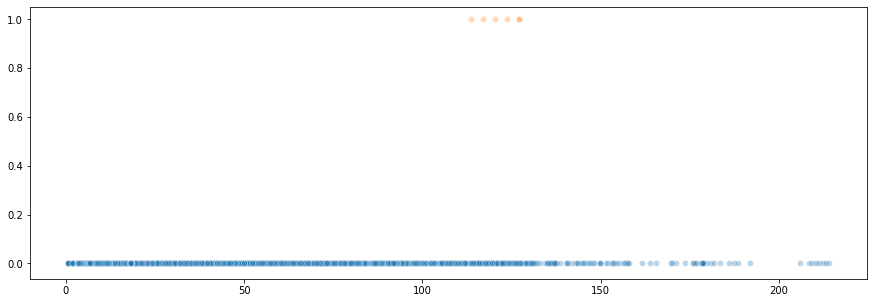

0.8788546255506607
country
Afghanistan            1
Albania                1
Algeria                1
Angola                 1
Antigua and Barbuda    1
                      ..
West Bank and Gaza     1
World                  1
Yemen, Rep.            1
Zambia                 1
Zimbabwe               1
Name: predict, Length: 227, dtype: int64


In [64]:
label, acc = runDBSCAN(df, 15, 0.3, 'euclidean')
print(acc)
plotCluster(df, label,"dbscan")

In [49]:
feature_g = {
        'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)',
        'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',
    target_id
}

In [65]:
df=transformDf(data, feature_g, True)
df=preprocessingMissing(df)
df= make_grade(df, 4)

In [69]:
bestParmGMM(df)

(0.2515619219291083, 3, 'spherical')

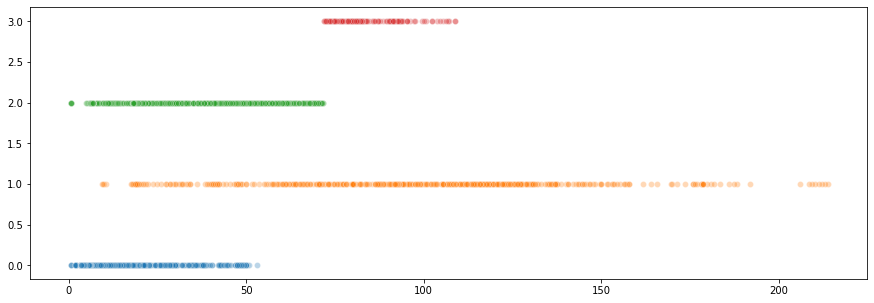

0.7560572687224669
country
Afghanistan            2
Albania                3
Algeria                1
Angola                 2
Antigua and Barbuda    1
                      ..
West Bank and Gaza     2
World                  1
Yemen, Rep.            2
Zambia                 2
Zimbabwe               2
Name: predict, Length: 227, dtype: int64


In [71]:
label, acc = runGMM(df, 4, 'spherical')
print(acc)
plotCluster(df, label,"gmm")

In [78]:
selection=selection_feature(feature,5)
print(len(feature))
print(len(selection))

3
0


In [64]:
selection=selection_feature(group_name,5)

In [79]:
feature

['GDP (constant LCU)',
 ['Population, ages 15-64',
  'Population, ages 0-14 (% of total)',
  'Birth rate, crude (per 1,000 people)',
  'Births attended by skilled health staff (% of total)',
  'Adolescent fertility rate (births per 1,000 women ages 15-19)'],
 'Adolescent fertility rate (births per 1,000 women ages 15-19)']

In [74]:
df=transformDf(data,feature_birth, True)
df=make_grade(df, 3)
df

IndicatorName,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Birth rate, crude (per 1,000 people)",Births attended by skilled health staff (% of total),"Population, ages 0-14 (% of total)",grade
name,,,,,
Afghanistan_2006,123.161600,43.893000,18.900000,47.696334,1.0
Afghanistan_2007,117.390000,42.779000,NaN,47.786807,1.0
Afghanistan_2008,111.470800,41.560000,24.000000,47.825228,1.0
Afghanistan_2009,105.551600,40.265000,NaN,47.766678,1.0
Afghanistan_2010,99.632400,38.940000,34.300000,47.589344,1.0
Afghanistan_2011,93.713200,37.636000,38.600000,47.100418,1.0
Afghanistan_2012,87.794000,36.396000,NaN,46.449243,1.0
Afghanistan_2013,82.263800,35.253000,NaN,45.685257,1.0
Albania_2006,18.727000,13.788000,99.000000,25.254356,0.0


In [67]:
df=preprocessingMissing(df)
df

NameError: name 'df' is not defined

In [68]:
all_feature={'feature_people':feature_people, 'feature_economy':feature_economy, 'feature_birth':feature_birth, 
             'feature_death':feature_death, 'feature_water':feature_water, 'feature_etc': feature_etc}
best_k = []
bst_score_k = []
    
for i in range(1,7):
    selection=selection_feature(group_name,i)
    for j in range(len(selection)):
        temp=list()
        subset=selection[j]
        for k in range(len(subset)):
            temp.append(all_feature[subset[k]])
        temp_ = temp[0]
        temp_.append('Adolescent fertility rate (births per 1,000 women ages 15-19)')
        df=transformDf(data,temp_ ,True)
        df=preprocessingMissing(df)
        
        print(bestParmKmeans(df))
        best_k.append(bestParmKmeans(df))
        best_score, best_cluster, best_iter = bestParmKmeans(df)
        bst_score_k.append(best_score)
        print(bst_score_k)
#        runKMeans(df, best_cluster, best_iter)       

(0.9441155202755546, 2, 300)
[0.9441155202755546]
(0.9861116586671461, 2, 300)
[0.9441155202755546, 0.9861116586671461]
(0.4329546448300447, 2, 300)


KeyboardInterrupt: 

In [86]:
#print(best_k)
print(bst_score)
#print(max(bst_score))

[(array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([1, 1, 1, ..., 1, 1, 1]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None), (array([0, 0, 0, ..., 0, 0, 0]), None),

In [ ]:
best_D = []
bst_score_D = []

for i in range(1,7):
    selection=selection_feature(group_name,i)
    for j in range(len(selection)):
        temp=list()
        subset=selection[j]
        for k in range(len(subset)):
            temp.append(all_feature[subset[k]])
        temp_ = temp[0]
        temp_.append('Adolescent fertility rate (births per 1,000 women ages 15-19)')
        df=transformDf(data,temp_ ,True)
        df=preprocessingMissing(df)
        
        print(bestParmDBSCAN(df))
        best_D.append(bestParmDBSCAN(df))
        best_score, best_eps, best_min, best_metric = bestParmDBSCAN(df)
        bst_score_D.append(runKDBSCAN(df, best_eps, best_min, best_metric))
        runKDBSCAN(df, best_eps, best_min, best_metric)

In [ ]:
best_G = []
bst_score_G = []

for i in range(1,7):
    selection=selection_feature(group_name,i)
    for j in range(len(selection)):
        temp=list()
        subset=selection[j]
        for k in range(len(subset)):
            temp.append(all_feature[subset[k]])
        temp_ = temp[0]
        temp_.append('Adolescent fertility rate (births per 1,000 women ages 15-19)')
        df=transformDf(data,temp_ ,True)
        df=preprocessingMissing(df)
        
        print(bestParmGMM(df))
        best_G.append(bestParmGMM(df))
        best_score, best_component, best_type = bestParmGMM(df)
        bst_score_G.append(runGMM(df, best_component, best_type))
        runGMM(df, best_component, best_type)


 ['Population, ages 15-64', 'Population, ages 0-14 (% of total)', 'Birth rate, crude (per 1,000 people)', 'Births attended by skilled health staff (% of total)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)'] 

(0.4329546448300447, 2, 300)


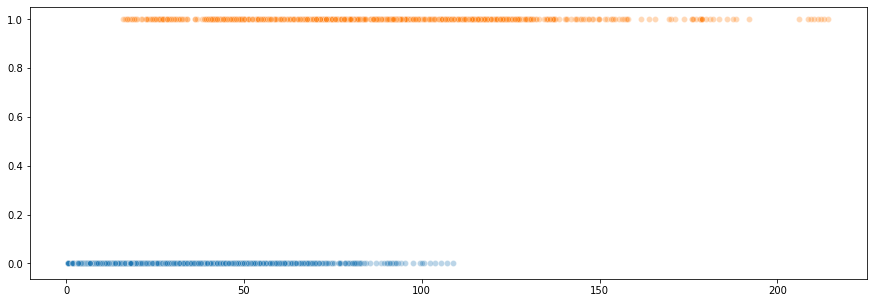

0.7538546255506607


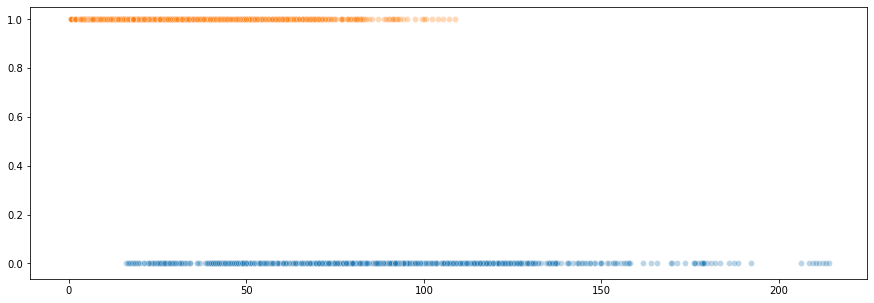

0.2461453744493392


(array([0, 0, 0, ..., 0, 0, 0]), None)

In [80]:
    best_k = []
    bst_score = []
    feature = feature_birth
    feature.append('Adolescent fertility rate (births per 1,000 women ages 15-19)')
    print('\n',feature,'\n')
    df=transformDf(data,feature,True)
    df=preprocessingMissing(df)
    '''
    print(runKMeans(df, 2,0, 0))
    print(runDBSCAN(df,10,5,'euclidean'))
    print(runGMM(df, 3))
    '''
    print(bestParmKmeans(df))
    best_k.append(bestParmKmeans(df))
    best_score, best_cluster, best_iter = bestParmKmeans(df)
    bst_score.append(runKMeans(df, best_cluster, best_iter))
    runKMeans(df, best_cluster, best_iter)

In [113]:
for i in range(len(selection)):
    print(i)
    best_k = []
    bst_score = []
    selection[i]=list(selection[i])
    selection[i].append('Adolescent fertility rate (births per 1,000 women ages 15-19)')
    print('\n',selection[i],'\n')
    df=transformDf(data,selection[i],True)
    df=preprocessingMissing(df)
    '''
    print(runKMeans(df, 2,0, 0))
    print(runDBSCAN(df,10,5,'euclidean'))
    print(runGMM(df, 3))
    '''
    print(bestParmKmeans(df))
    best_k.append(bestParmKmeans(df))
    best_score, best_cluster, best_iter = bestParmKmeans(df)
    best_score.append(runKMeans(df, best_cluster, best_iter))
    runKMeans(df, best_cluster, best_iter)

0

 ['feature_people', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)'] 

one
(0, 2, 50)
one
one


AttributeError: 'int' object has no attribute 'append'

In [27]:
'''
n_clusters = 3
max_iter = 300
Scaler: robust

Eps= 0.3
min_samples = 15
Metric = ‘Euclidean’
Scaler: minmax

n_clusters = 5
Covariance_type = ‘Spherical’
Scaler: minmax


'''

'\nn_clusters = 3\nmax_iter = 300\nScaler: robust\n\nEps= 0.3\nmin_samples = 15\nMetric = ‘Euclidean’\nScaler: minmax\n\nn_clusters = 5\nCovariance_type = ‘Spherical’\nScaler: minmax\n\n\n'

In [ ]:
plotCluster(df_plot,"","origin")

In [80]:
feature_k = {
        'Prevalence of anemia among children (% of children under 5)',
    'Age dependency ratio, young (% of working-age population)',
    'Adjusted net national income (current US$)',
    'CPIA gender equality rating (1=low to 6=high)',
    'Annualized average growth rate in per capita real survey mean consumption or income, total population (%)'
        'GDP (constant LCU)' ,
        'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)',
        'Life expectancy at birth' ,
    'Lifetime risk of maternal death (%)'
    'Life expectancy at birth, total (years)',
    'female (years),Life expectancy at birth, male (years)',
    'Survival to age 65, female (% of cohort)',
    'Mortality rate, adult, female (per 1,000 female adults)',
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
            'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',
    'Net enrolment rate, secondary, both sexes (%)',
    'Net enrolment rate, secondary, female (%)', 
    'Net enrolment rate, secondary, male (%)',
    target_id
}

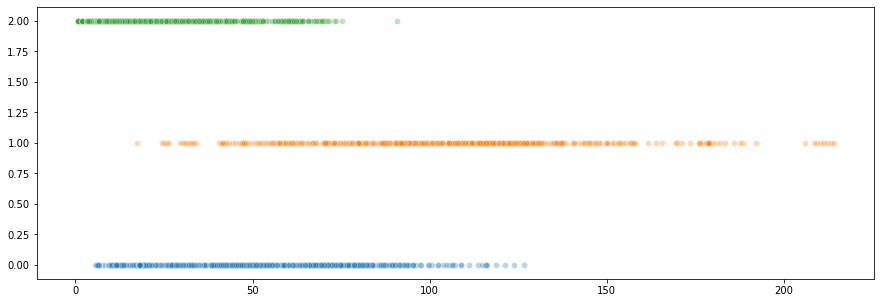

1816
1816


In [115]:
feature_d = {
        'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)',
        'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',
    target_id
}

[-1 -1 -1 ... -1 -1 -1]


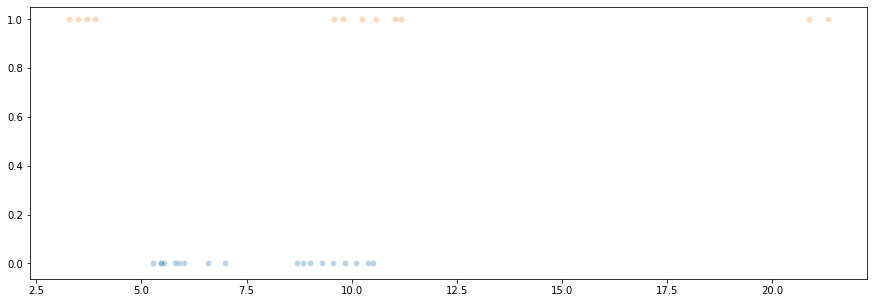

0.7224669603524229


In [132]:
df=transformDf(data, feature_d, True)
df=preprocessingMissing(df)
df= make_grade(df, 4)
label, acc = runDBSCAN(df,0.3, 10, "euclidean")
print(acc)
plotCluster(df, label,"dbscan")

In [117]:
feature_g = {
        'Population, ages 15-64',   
    'Population, ages 0-14 (% of total)',
    'Birth rate, crude (per 1,000 people)',
    'Births attended by skilled health staff (% of total)',
        'Improved water source (% of population with access)',
    'Improved water source, rural (% of rural population with access)',
    target_id
}

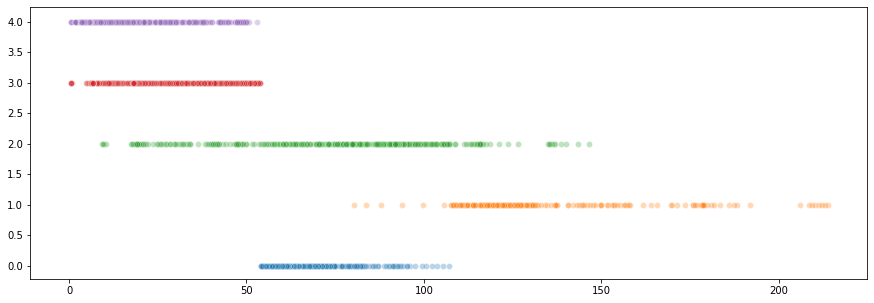

0.7252202643171806


In [128]:
df=transformDf(data, feature_g, True)
df=preprocessingMissing(df)
df= make_grade(df, 4)
label, acc = runGMM(df, 5, 'spherical')
print(acc)
plotCluster(df, label,"dbscan")

In [131]:
plotCluster(df_plot,label,"kmeans")

[-1 -1 -1 ...  2  2  2]


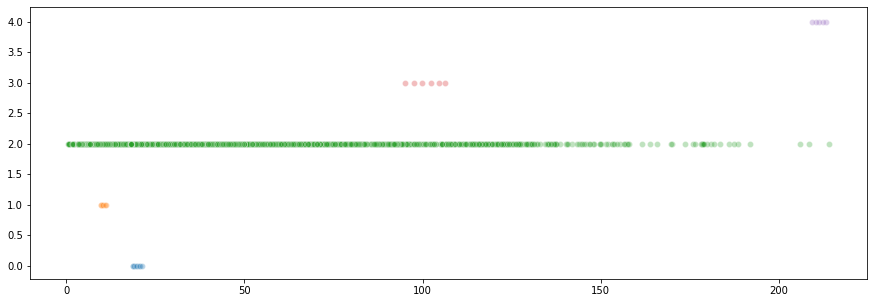

0.1486784140969163


In [126]:
runDBSCAN(df,10,5,'euclidean')

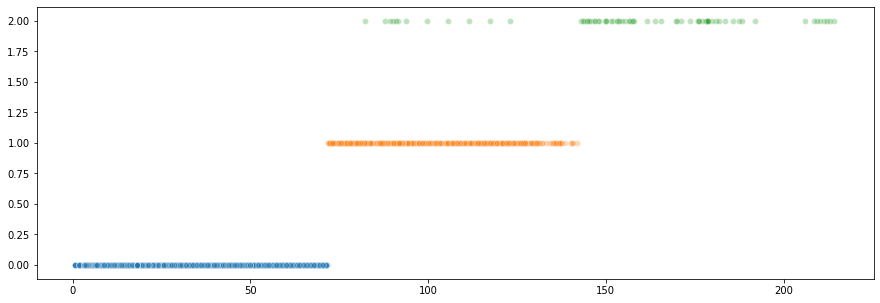

0.9933920704845814


In [161]:
runGMM(df, 3)

In [117]:
'''
선택지
1. rel_columns_8 or 7
2. 몇개 미만이면 제외할지
3. kmeans parameter
'''

'\n선택지\n1. rel_columns_8 or 7\n2. 몇개 미만이면 제외할지\n3. kmeans parameter\n'

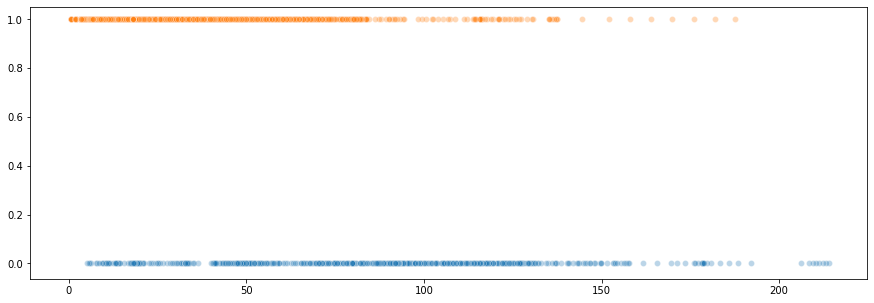

0.2615638766519824


(array([0, 0, 0, ..., 0, 0, 0]), None)

In [125]:
runKMeans(df,2,600,30)

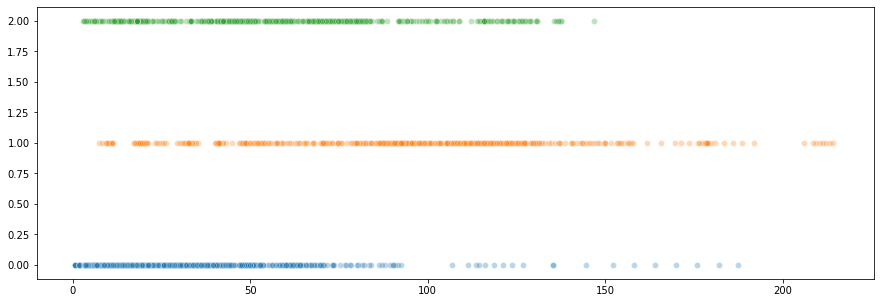

0.5748898678414097


(array([1, 1, 1, ..., 1, 1, 1]), None)

In [124]:
runKMeans(df,3,600,30)

[-1 -1 -1 ...  3  3  3]


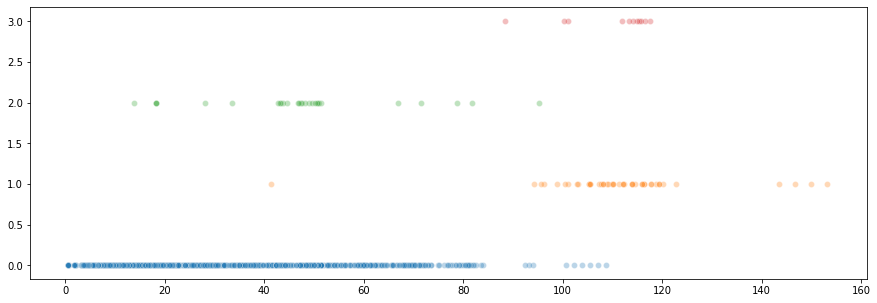

0.355726872246696


In [121]:
runDBSCAN(df,5,10,'euclidean')

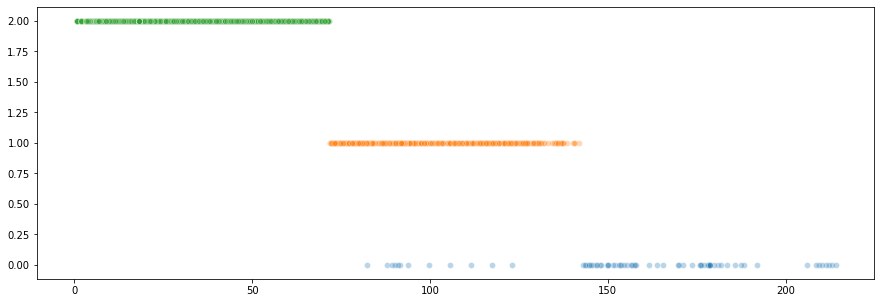

0.23788546255506607


In [122]:
runGMM(df, 3)